```
conda install nb_conda_kernels
```

Facebook's Prophet needs 3.6:

```
conda create -n prophet python=3.6
conda activate prophet
conda install -c anaconda jupyter
conda install -c conda-forge fbprophet
conda install -c plotly plotly
```

To get out:

```
conda deactivate
```

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

from fbprophet import Prophet

## Prophet

Prophet is a procedure for forecasting time series data. It is based on an additive model where non-linear trends are fit with yearly and weekly seasonality, plus holidays. It works best with daily periodicity data with at least one year of historical data. Prophet is robust to missing data, shifts in the trend, and large outliers.

That's all to say that if you give Prophet historical data, it will attempt to extrapolate into the future for you.

Installing Prophet on to your machine is a bit more involved, but the [README](https://github.com/facebook/prophet#installation-in-python) is incredibly detailed...

## Purchases

In order to demonstrate how Prophet works, we need some historical data.  I thought it would be fun to use some of my own personal data.

The `purchases.csv` file, contains all of my Amazon purchases since 2012. It has 83 rows and two columns (date and amount spent). 

Loading up pandas and the purchases data:

In [2]:
import pandas as pd
purchases = pd.read_csv('data/purchases.csv')

We can see that I spent `$17.99` on 2018-01-07 and `$158.19` on 2018-01-31:

In [3]:
print(purchases.tail())

          date  amount
78  2017-12-24   62.53
79  2017-12-27   43.99
80  2017-12-28   21.99
81  2018-01-07   17.99
82  2018-01-31  158.19


Rolling the values into a running total can be accomplished with:

In [4]:
purchases['cumsum'] = purchases['amount'].cumsum()
print(purchases.tail())

          date  amount   cumsum
78  2017-12-24   62.53  4906.19
79  2017-12-27   43.99  4950.18
80  2017-12-28   21.99  4972.17
81  2018-01-07   17.99  4990.16
82  2018-01-31  158.19  5148.35


Disturbingly, I've spent a grand total of \$5148.35 on Amazon since 2012...

## Forecast

In order to forecast with Prophet we need to massage the purchases `DataFrame` to conform to a specific input structure. Prophet inputs are always a `DataFrame` with two columns: ds and y. The `ds` (datestamp) column must contain a date and the `y` column must be numeric, and represents the measurement we want to forecast:

In [5]:
purchases = purchases[['date', 'cumsum']]
purchases.columns = ['ds', 'y']
print(purchases.head())

           ds       y
0  2012-07-25   82.55
1  2012-12-10  143.56
2  2013-02-19  155.10
3  2013-02-24  221.77
4  2013-04-20  229.76


Let's import Prophet:

In [6]:
from fbprophet import Prophet

Instantiate an instance of the Prophet class and fit it to the purchases data:

In [7]:
m = Prophet(daily_seasonality=False)
m.fit(purchases)

/Users/max/anaconda3/envs/prophet/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In order to forecast values one year into the future we need to use the `.make_future_dataframe` method with periods argument set to 365:

In [8]:
future = m.make_future_dataframe(periods=365)
print(future.tail())

            ds
443 2019-01-27
444 2019-01-28
445 2019-01-29
446 2019-01-30
447 2019-01-31


Predicting my total spending on Amazon through 2018 and into 2019 is now dead simple. We just have to call the `predict`  method on top of the future `DataFrame` that we created above:

In [9]:
forecast = m.predict(future)

Inspecting the forecast object:

In [10]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
443,2019-01-27,7865.047370,7625.255328,8089.978098
444,2019-01-28,7833.884060,7600.800946,8055.177650
445,2019-01-29,7828.956003,7576.605178,8053.761528
446,2019-01-30,7878.670101,7636.811020,8104.589510
447,2019-01-31,7934.337339,7691.147980,8149.710813


We can see that I am meant to spend a cumulative total of \$7985 (yhat) on Amazon. But now that I know that I'm keen to ratchet back my spending!

## Visualize

Prophet comes packaged with a really great `plot` convenience method. Running it on top of the `m` object we can get a better sense of the trend:

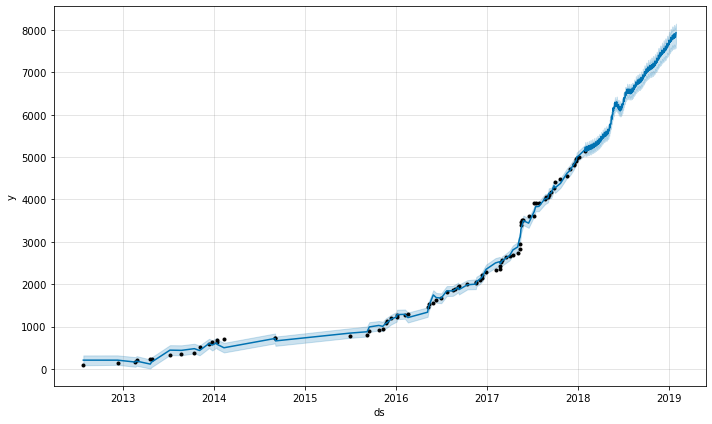

In [11]:
pd.plotting.register_matplotlib_converters()

m.plot(forecast);

The library also includes a `plot_components` method that prints panels for trend, weekly and yearly seasonalities if present:

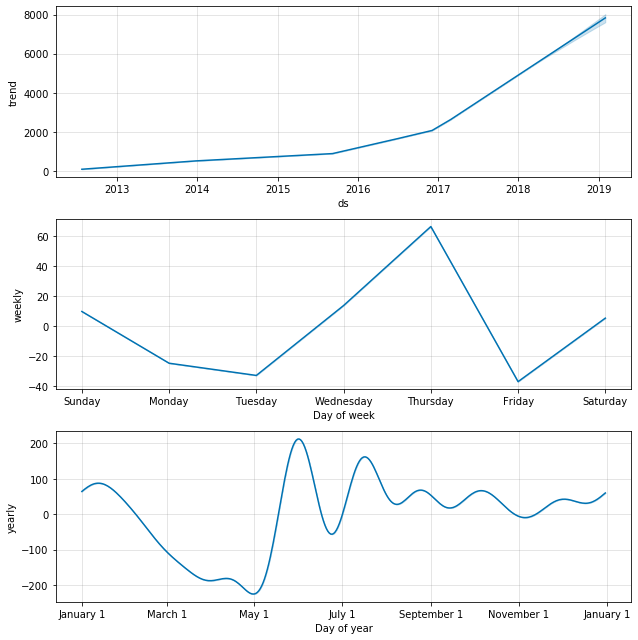

In [12]:
m.plot_components(forecast);